# 08. Milestone Project 2: PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Iransformer (ViT) architecture/paper with PyTorch: https://arxiv.org/abs/2010.11929


## 0. Get Setup
Let's import code we've previously written + required libraries.

In [26]:
import matplotlib.pyplot as plt
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchinfo import summary
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [27]:
# Setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

## 1. Get data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak and sushi images we've been using so far.

In [28]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [29]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [30]:
from going_modular import data_setup

# Create image size
IMAGE_SIZE = 224 # Comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

print (f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [31]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our smaller hardware... can always scale up late
BATCH_SIZE = 32

# Create DataLoaders
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               train_transform=manual_transforms,
                                                                               test_transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [32]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

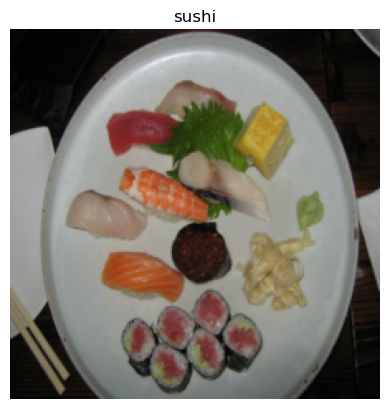

In [33]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be intimidating.

So in order to make it more understandable, we can break it down into smaller pieces.

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks** - A collection of layers.
* **Model** - A collection of blocks.

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for archtitecture/training.
* Text

### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over
time)

### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

#### Section 3.1: describes the various equations

**Equation 1:**
> An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 4:**
> Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left (\mathbf {z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf {z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

**Equation 1:**
> Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm(D)$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

**Equation 2&3:**
> The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded self attention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski l& Auli, (2019).

### Table 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper" />

# \# Progress updates

In [40]:
from Progress.course_progress_func import update_progress, progress_pie_chart, monthly_progress, progress_report_print

update_progress(video_index=232, done=True)

Updated progress report. 
Video: 232. Breaking Down the Four Equations Overview and a Trick for Reading Papers 
Duration: 11m 
Status: Done 
Date: 22 Dec 2025 10:21 AM 
Section progress: 
Section : 10.PyTorch Paper Replicating
Status  : 39 videos remaining, 6h 42m to finish the section
Progress:  22%|██████▍                       11/50


In [41]:
progress_report_print()

      ___         ___           ___           ___           ___           ___           ___           ___     
     /  /\       /  /\         /  /\         /  /\         /  /\         /  /\         /  /\         /  /\    
    /  /::\     /  /::\       /  /::\       /  /:/_       /  /::\       /  /:/_       /  /:/_       /  /:/_   
   /  /:/\:\   /  /:/\:\     /  /:/\:\     /  /:/ /\     /  /:/\:\     /  /:/ /\     /  /:/ /\     /  /:/ /\  
  /  /:/~/:/  /  /:/~/:/    /  /:/  \:\   /  /:/_/::\   /  /:/~/:/    /  /:/ /:/_   /  /:/ /::\   /  /:/ /::\ 
 /__/:/ /:/  /__/:/ /:/___ /__/:/ \__\:\ /__/:/__\/\:\ /__/:/ /:/___ /__/:/ /:/ /\ /__/:/ /:/\:\ /__/:/ /:/\:\
 \  \:\/:/   \  \:\/:::::/ \  \:\ /  /:/ \  \:\ /~~/:/ \  \:\/:::::/ \  \:\/:/ /:/ \  \:\/:/~/:/ \  \:\/:/~/:/
  \  \::/     \  \::/~~~~   \  \:\  /:/   \  \:\  /:/   \  \::/~~~~   \  \::/ /:/   \  \::/ /:/   \  \::/ /:/ 
   \  \:\      \  \:\        \  \:\/:/     \  \:\/:/     \  \:\        \  \:\/:/     \__\/ /:/     \__\/ /:/  
 